<a href="https://colab.research.google.com/github/nsanghi/drl-2ed/blob/main/chapter6/6.c-dqn_atari_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN - Deep Q-Network  (PyTorch) - Play Atari game.

In this notebook, we will use DQN with **experience replay** and **target networks** from `6.a-dqn-pytorch` to train the agent to play Atari game. Most of the implementation will be same as previous one, except some pre-processing to make Atari game playing trainable with DQN.

The deep learning approach combined with Q-Learning and word `DQN` was coined in this paper. We have tried to broadly follow the steps of the paper in this notebook

Paper: [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf)

### Recap from last notebook

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use $\epsilon$-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update.

In case of function approximation using neural network, the input to the network is the state and output is the $q(s,a)$ for all the actions in the state $s$. It is denoted as $ \hat{q}(s_t, a_t; w_{t}) $, where $w_{t}$ is the weigths of the neural network that we learn as part of DQN learning.

We use two networks, one target network with weight $w^-_t$ to get the max $q$-value of next state with best action denoted by $ \max\limits_a \hat {q}(S_{t+1},a; w^{-}_{t}) $ and network with weights $w_t^-$ which we periodically updated from primary network $w_t$.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a;w^{-}_{t}) – \hat{q}(S_t,A_t;w_t)] \nabla \hat{q}_{w_t}(S_t,A_t;w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values.

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions `(current state, action, reward, next state)` in a buffer, where each sample is denoted as a tuple:

$$ (s_{i}, a_{i}, r_{i}, s'_{i}, done_{i})$$

Subscript ($i$) denotes ith sample. We take $N$ samples from experience replay selecting randomly and update the weights. Subscript ($t$) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_{i},a';w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


### Colab Installs

In [ ]:
# uncomment and execute this cell to install all the the dependencies if running in Google Colab
# takes about 10-12 minutes to install all the dependencies esp the ones with RL Zoo

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo
# %cd /content/rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode

from IPython.display import HTML

%matplotlib inline

2023-11-13 13:57:11.297960: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 13:57:11.359676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 13:57:11.772554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 13:57:11.772629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 13:57:11.780685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Environment - Atari Breakout

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Atari Breakout.


In [2]:
def make_env(env_name, frameskip=5, repeat_action_probability=0.25, render_mode='rgb_array', mode=0, difficulty=0):
    # remove time limit wrapper from environment
    env = gym.make(env_name,
                   render_mode=render_mode,
                   frameskip=frameskip,
                   repeat_action_probability=repeat_action_probability,
                   mode=mode,
                   difficulty=difficulty
                  ).unwrapped
    return env

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


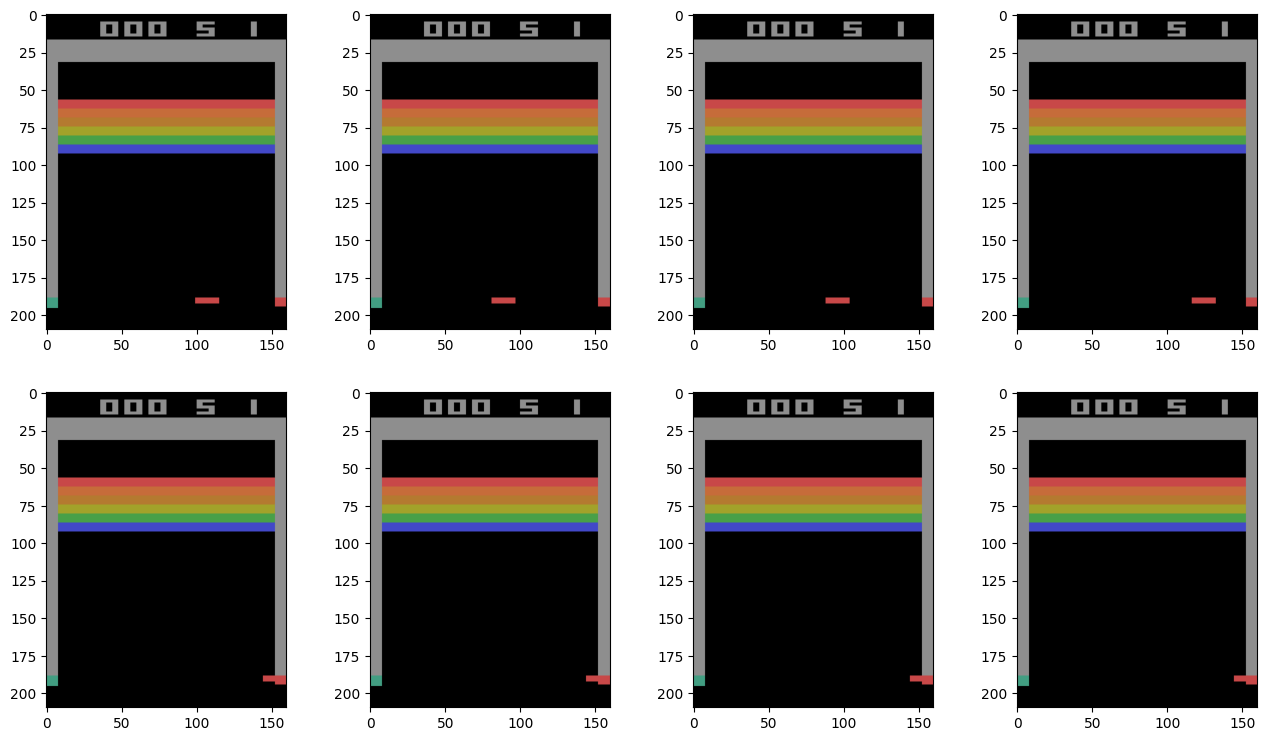

In [3]:
env_name = "ALE/Breakout-v5"

env = make_env(env_name)
env.reset(seed=127)

n_cols = 4
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

#### We can play the game

use `A` and `D` on keyboard to move the bat and `Space-bar` to start. use `Esc` to kill the game.

**NOTE: Running the cell below may crash your kernel in Mac. If you face that problem, please comment the cell below or do not run it**.

In [4]:
from gymnasium.utils.play import play

play(env=gym.make(env_name,
                  render_mode='rgb_array',
                  frameskip=1,
                  repeat_action_probability=0.0,
                  mode=0,
                  difficulty=0
                 ), zoom=3.5, fps=30)

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/utils/play.py:29: UserWarning: WARN: matplotlib is not installed, run `pip install gymnasium[other]`
  logger.warn("matplotlib is not installed, run `pip install gymnasium[other]`")
/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_keys_to_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_keys_to_action` for environment variables or `env.get_wrapper_attr('get_keys_to_action')` that will search the reminding wrappers.
  logger.warn(
/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


### Pre processing

Atari images are 210x160x3 pixels but we will scale it down and also convert to gray-scale to reduce the size and make the game learn faster from smaller image sizes. We will also stack 4 last frames as input observation. This is done to capture the motion of the ball and bat which would not be visible in a single frame of game. Gymnasium library has ObservationWrappers to provide all these pre-processing out of the box. We will also be clipping rewards with just the sign of rewards. This is following the approach outlined in original paper. Let us build our preprocessor below

In [8]:
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers import TransformReward

def make_env(env_name,
             clip_rewards=True):

    env = gym.make(env_name,
                   render_mode='rgb_array',
                   frameskip=1
              )
    env = AtariPreprocessing(env, screen_size=84, scale_obs=True)
    env = FrameStack(env, num_stack=4)
    if clip_rewards:
        env = TransformReward(env, lambda r: np.sign(r))
    return env

env = make_env(env_name)
obs, _ = env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

In [12]:
print("Observation Shape:", state_shape)
print("Actions Array:", env.get_action_meanings())

Observation Shape: (4, 84, 84)
Actions Array: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


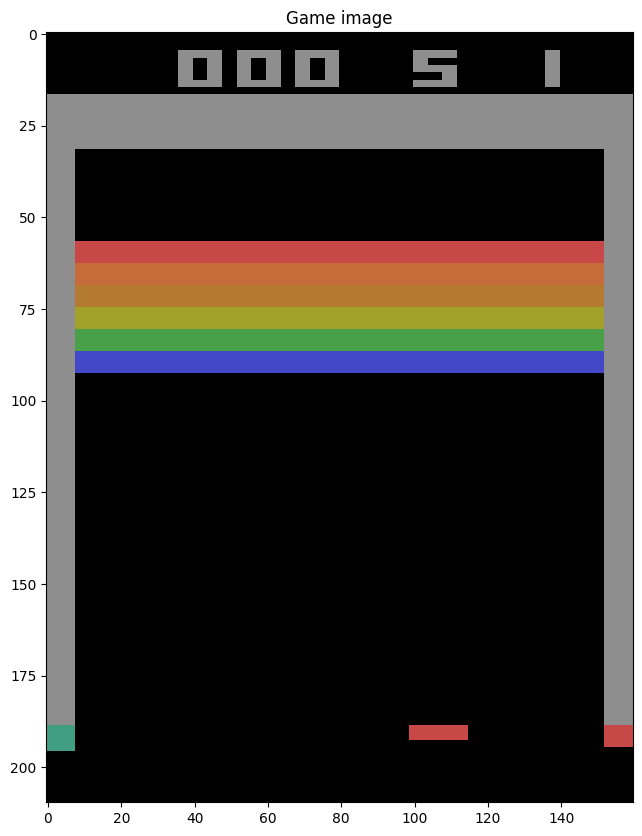

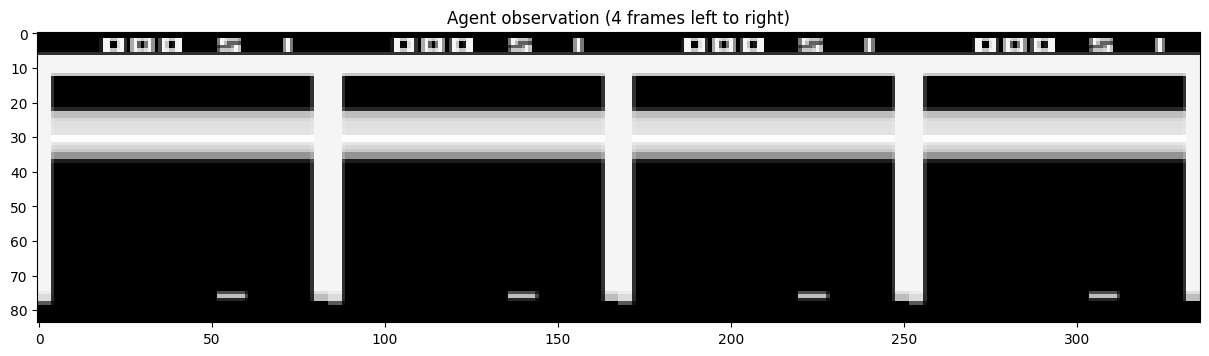

In [10]:
# for _ in range(12):
#     obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

obs = obs[:] #unpack lazyframe
obs = np.transpose(obs,[1,0,2]) #move axes
obs = obs.reshape((obs.shape[0], -1))


plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs, cmap='gray')
plt.show()

### Building a network using pytorch

Let us build a DQN agent using the architecture suggested in paper.

    Observation:
        pytorch 4x84x84 pytroch has channels in the first dimension
        input: [batch_size, 4, 84, 84]
        1st hidden layer: 16 8x8 filters with stride 4 and RelU activation
        2nd hidden layer: 32 4x4 filters with stride of 2 and RelU activation
        3nd hidden layer: Linear layer with 256 outputs and RelU activatrion
        output layer: Linear with n_actions units with no activation

To build this network, after 2 layers of convolution, we will flatten the layers. To connect this to Dense(Linear) layer, we need to calculate the number of units entering dense layer. We do so using the formula for Conv2D output.

`out_dim = (in_dim - (kernel_size - 1) - 1) // stride  + 1`

In [13]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [14]:
# for the network above
# 1st Conv layer output size
conv1 = conv2d_size_out(84, 8, 4)
print('Conv1: ', conv1)
conv2 = conv2d_size_out(conv1, 4, 2)
print('Conv1: ', conv2)

#number of units entering dense layer would be
print("Input to Dense layer:", conv2*conv2*32) #32 is number of filters coming out in 2nd conv layer

Conv1:  20
Conv1:  9
Input to Dense layer: 2592


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('conv1', nn.Conv2d(4,16,kernel_size=8, stride=4))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('conv2', nn.Conv2d(16,32,kernel_size=4, stride=2))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('flatten', nn.Flatten())
        self.network.add_module('linear3', nn.Linear(2592, 256)) #2592 calculated above
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('linear4', nn.Linear(256, n_actions))

        self.parameters = self.network.parameters

    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [17]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [18]:
print(agent.network)

Sequential(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=2592, out_features=256, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=256, out_features=4, bias=True)
)


In [14]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [15]:
evaluate(env, agent, n_games=1)

<ipython-input-12-cd555dad720a>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(states, device=device, dtype=torch.float32)


0.0

In [16]:
env.close()

### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon$-greedy) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient.

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [17]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to hold buffer
        self.next_id = 0

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [18]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        next_s, r, terminated, truncated, _ = env.step(a)
        sum_rewards += r
        done = terminated or truncated
        exp_replay.add(s, a, r, next_s, done)
        if terminated:
            s, _ = env.reset()
        else:
            s = next_s

    return sum_rewards, s

### Target network


In [19]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with DQN
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation:

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}_{w_t}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_{w_t} L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}_{w_t}(s_i,a_i;w_t)$$


$\hat{q}(s',a';w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network.

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max\limits_{a'} \hat{q}(s'_i,a';w^-_t)$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$
w_{t+1} \leftarrow w_t - \alpha . \nabla_{w_t}L$$

In [20]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values"
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

### Main loop

We now carryout the training on DQN setup above.

In [21]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [22]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [23]:
#setup env and agent and target networks
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [24]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [25]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32

total_steps = 100
# total_steps = 3 * 10**6
# We will train only for a sample of 100 steps
# To train the full network on a CPU will take hours.
# infact even GPU training will be fairly long
# Those who have access to powerful machines with GPU could
# try training it over 3-5 million steps or so


#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 1 * 10**6

# setup some frequency for logging and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [26]:
mean_rw_history = []
td_loss_history = []

In [27]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 1.00000


<ipython-input-27-4cdb163d8b5a>:5: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(100, std=100)


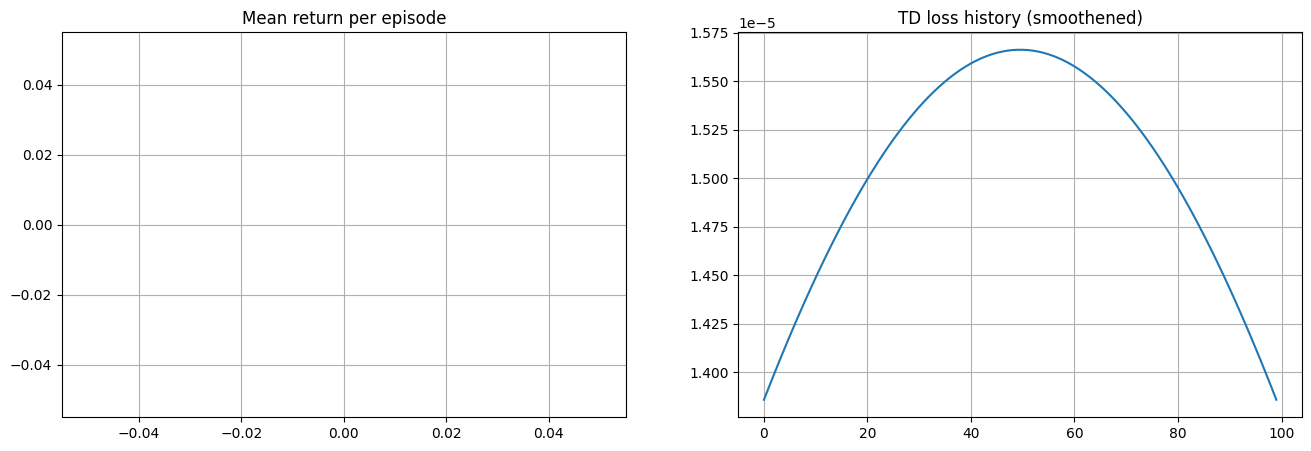

100%|██████████| 101/101 [00:26<00:00,  3.86it/s]


In [28]:
state, _ = env.reset()
for step in trange(total_steps + 1):

    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)


    # loss = <compute TD loss>
    loss = compute_td_loss(agent, target_network,
                           states, actions, rewards, next_states, done_flags,
                           gamma=0.99,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean return per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [29]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=1, greedy=True, t_max=1000
)
print('final score:', final_score)


final score: 0.0


The training for 100 steps will not produce any result. It may be close to 100,000 steps or so before you see any semblance of learning by agent. Do not worry about the exceptions above. That is because the first graph has no data point for 100 steps. First data point for the left graph is generated only at 1000th step.

**Let us record a video of trained agent**

In [30]:
# Helper function to record videos
def record_video(env_id, make_env, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: make_env(env_id, clip_rewards=False)])
    env_id_suffix = env_id.split("/")[-1]
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id_suffix}")

    obs = vec_env.reset()
    print(obs.shape)
    for _ in range(video_length + 1):
        qvalues = agent.get_qvalues(obs)
        action = qvalues.argmax(axis=-1)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

In [31]:
video_folder = "logs/videos/pytorch/6_b/"
video_length = 500

video_file = record_video(env_name, make_env, video_folder, video_length, agent)
play_video(video_file)

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


(1, 4, 84, 84)
Saving video to /content/logs/videos/pytorch/6_b/DQNAgent-Breakout-v5-step-0-to-step-500.mp4
Moviepy - Building video /content/logs/videos/pytorch/6_b/DQNAgent-Breakout-v5-step-0-to-step-500.mp4.
Moviepy - Writing video /content/logs/videos/pytorch/6_b/DQNAgent-Breakout-v5-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/videos/pytorch/6_b/DQNAgent-Breakout-v5-step-0-to-step-500.mp4


### Train using RL_Zoo3
We will also be using Weights and Biases to records the run and other experiment details. For this we need to login using the wandb api key

In [32]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Train agent

We will use DQN. Earlier we had defined env_name as `env_name = "ALE/Breakout-v5"`. However for the current version we will use the same environment from Version 4. You can read more about the available environments [here](https://gymnasium.farama.org/environments/atari/breakout/) and [here](https://gymnasium.farama.org/environments/atari/). The difference is in terms of default values of `repeat_action_probability` and `frameskip`. For RL ZOO 3 we will use `BreakoutNoFrameskip-v4`

#### Sample run with CPU
To keep run time within bounds you can use this script where the number of training steps have been kept small


In [33]:
# CPU version where `n-timesteps` value has been scaled down.
# For a good run esp if you have GPU, change it to 10 million i.e. 10000000

# !python -m rl_zoo3.train --algo dqn --env BreakoutNoFrameskip-v4 --n-timesteps 500000 --save-freq 10000 \
# --eval-freq 10000 --eval-episodes 10 --log-interval 400 --progress \
# --track --wandb-project-name dqn-breakout -f logs/6_c/rlzoo3/


# example GPU script

!python -m rl_zoo3.train --algo dqn --env BreakoutNoFrameskip-v4 --n-timesteps 10000000 --save-freq 100000 \
--eval-freq 25000 --eval-episodes 10 --progress \
--track --wandb-project-name dqn-breakout-gpu -f logs/6_c/rlzoo3/

Streaming output truncated to the last 5000 lines.
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.38     |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 9136     |
|    fps              | 266      |
|    time_elapsed     | 1516     |
|    total_timesteps  | 404168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 76041    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.38     |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 9140     |
|    fps              | 266      |
|    time_elapsed     | 1517     |
|    total_timesteps  | 404452   |
| train/              |          |
|   

In [34]:
#### Evaluate Trained Agent

!python -m rl_zoo3.enjoy --algo dqn --env BreakoutNoFrameskip-v4 --no-render --n-timesteps 5000 --folder logs/6_c/rlzoo3

2023-11-05 07:10:13.007694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 07:10:13.007751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 07:10:13.007787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 07:10:16.697761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_c/rlzoo3/dqn/BreakoutNoFrameskip-v4_1/BreakoutNoFrameskip-v4.zip
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
Stacking 4 frames
Atari Episode Score: 4.00
Ata

#### Record a video

In [36]:
!python -m rl_zoo3.record_video --algo dqn --env BreakoutNoFrameskip-v4 --exp-id 0 -f logs/6_c/rlzoo3/ -n 5000

2023-11-05 07:11:17.725095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 07:11:17.725154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 07:11:17.725205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 07:11:18.901881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_c/rlzoo3/dqn/BreakoutNoFrameskip-v4_1/BreakoutNoFrameskip-v4.zip
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
Stacking 4 frames
Loading logs/6_c/rlzoo3/dqn/B

In [37]:
video_file_rlzoo = "logs/6_c/rlzoo3/dqn/BreakoutNoFrameskip-v4_1/videos/final-model-dqn-BreakoutNoFrameskip-v4-step-0-to-step-5000.mp4"
play_video(video_file_rlzoo)

#### Share on Huggingface

In [39]:
from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

notebook_login()
!git config --global credential.helper store

In [41]:
!python -m rl_zoo3.push_to_hub --algo dqn --env BreakoutNoFrameskip-v4 --exp-id 0 \
--folder logs/6_c/rlzoo3 --n-timesteps 5000 --verbose 1 --load-best  \
--organization nsanghi --repo-name dqn-atari-breakout-rlzoo-gpu -m "Push to Hub"

2023-11-05 07:16:10.962557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 07:16:10.962621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 07:16:10.962655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 07:16:12.104351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=1
Loading logs/6_c/rlzoo3/dqn/BreakoutNoFrameskip-v4_1/best_model.zip
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
Stacking 4 frames
Wrapping the env in a VecTransposeImage.


### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks to play Atari game. If you have access to a GPU, try to train the agent and see how well it plays. We can improve the agent further with many tricks and there are many more papers detailing such attempts. As we go along, we will be implementing many of these variants.